Topic Modeling
============



```{admonition} Learning Objectives
By the end of this chapter, you will be able to:

+ Explain what a topic model is, what it represents, and how to use one to explore a corpus
+ Build a topic model
+ Appraise the validity of a topic model and fine tune it accordingly
```

Data Setup
-------------

### File manifest

As before, we'll use a file manifest to keep things orderly.

In [1]:
import pandas as pd

manifest = pd.read_csv("data/session_three/manifest.csv", index_col = 0)
manifest['PUB_DATE'] = pd.to_datetime(manifest['PUB_DATE'], format="%Y-%m-%d")

print(
    f"Number of blurbs: {len(manifest)}",
    f"\nDate range: {manifest['PUB_DATE'].dt.year.min()}--{manifest['PUB_DATE'].dt.year.max()}",
    f"\nGenres: {', '.join(manifest['GENRE'].unique().tolist())}"
)

manifest.sample(5)

Number of blurbs: 1500 
Date range: 1958--2018 
Genres: Fiction, Classics, Nonfiction, Children’s Books, Teen & Young Adult, Poetry, Humor


,AUTHOR,TITLE,GENRE,PUB_DATE,ISBN,FILE_NAME
1450,Lora Leigh,Too Hot to Touch,Fiction,2015-10-06,9780698183995,1450.txt
301,"Bruce E. Hunsberger, Bob Altemeyer",Atheists,Nonfiction,2006-06-01,9781591024132,0301.txt
1306,Erich Segal,"Man, Woman, and Child",Fiction,1993-03-01,9780553562354,1306.txt
75,C.M. Palov,The Templar's Code,Fiction,2010-11-02,9780425237731,0075.txt
997,"Hubie Karp, Merrill De Maris",Silly Symphonies Volume 3: The Complete Disney...,Humor,2017-12-12,9781631409882,0997.txt


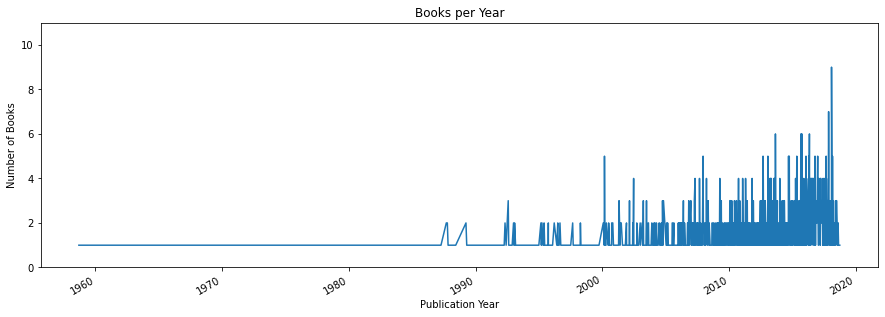

In [2]:
manifest.groupby('PUB_DATE')['ISBN'].count().plot(figsize = (15, 5),
                                                  title = "Books per Year",
                                                  xlabel = "Publication Year",
                                                  ylabel = "Number of Books",
                                                  ylim = (0, 11)
                                                  );

### Document-term matrix

We'll also quickly make a document-term matrix with `scikit-learn`'s `CountVectorizer()`. But since we don't need 
to do any preprocessing on our files, we'll just have `CountVectorizer()` stream in the files itself using its 
`input` argument. All we need to do is give it the list of filenames from our manifest and it will take care of the 
rest.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

indir = "data/session_three/input/"
file_names = (indir + manifest['FILE_NAME']).tolist()

vectorizer = CountVectorizer(input = 'filename')
vectorized = vectorizer.fit_transform(file_names)

dtm = pd.DataFrame(
    vectorized.toarray(),
    index = manifest['TITLE'],
    columns = vectorizer.get_feature_names_out()
)

Let's take a quick look to ensure this process has worked the way we expected it to work.

In [4]:
dtm.loc[dtm.sample(5).index, dtm.sample(15, axis = 1).columns]

,tollbooth,italian,activityreading,adhere,campaign,biden,mood,cinematically,fanfare,melt,dreidel,zapruder,daemon,radicalize,preeminent
TITLE,,,,,,,,,,,,,,,
School of Dragons #1: Volcano Escape! (DreamWorks Dragons),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Otto the Cat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Steampunk LEGO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Taste of Ashes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dennett and Ricoeur on the Narrative Self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Quite sparse, but that's to be expected.

We'll also assign the corpus vocabulary and individual blurbs' token counts to variables, which will be useful 
later on.

In [5]:
vocab = vectorizer.get_feature_names_out()
doc_lengths = dtm.sum(axis = 1)

print(
    f"Vocabulary size: {len(vocab)} tokens",
    f"\nAverage blurb length: {doc_lengths.mean():.0f} tokens"
)

Vocabulary size: 19608 tokens 
Average blurb length: 86 tokens


Building a Topic Model
---------------------------